1. Data Collection

In [ ]:
# Run this in a Jupyter cell
%pip install pandas numpy matplotlib scikit-learn yfinance xgboost transformers torch
%pip install praw sentencepiece nltk textblob wordcloud scipy tqdm

In [1]:
# Using PRAW (Python Reddit API Wrapper)
import praw
import pandas as pd
from datetime import datetime

# Initialize Reddit API client
reddit = praw.Reddit(
    client_id="pfyynho01jid0krVEI_u-w",
    client_secret="6gyxgyDF2SZmgNBGZroI7y_2U5am1w",
    user_agent="WallStreetScrapper/1.0",
    # username="YOUR_USERNAME",  # Optional
    # password="YOUR_PASSWORD"   # Optional
)

# Access the wallstreetbets subreddit
subreddit = reddit.subreddit("wallstreetbets")

# Collect posts
posts = []
for post in subreddit.top(time_filter="month", limit=1000):  # Adjust time period and limit as needed
    posts.append({
        "title": post.title,
        "score": post.score,
        "id": post.id,
        "url": post.url,
        "comms_num": post.num_comments,
        "created": datetime.fromtimestamp(post.created),
        "body": post.selftext
    })
    
# Convert to DataFrame
posts_df = pd.DataFrame(posts)
posts_df.to_csv("wsb_posts.csv", index=False)

Version 7.7.1 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


2. Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# NLTK resources are downloaded
import nltk
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('vader_lexicon')
except Exception as e:
    print(f"Failed to download NLTK resources: {e}")


# Load data
df = pd.read_csv("wsb_posts.csv")

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Create sentiment scores
def get_sentiment(text):
    if isinstance(text, str) and text.strip():
        return sia.polarity_scores(text)['compound']
    return 0  # neutral for empty/non-string values

# Apply to your text column (title, body, or both)
if 'title' in df.columns:
    df['sentiment_score'] = df['title'].apply(get_sentiment)
elif 'body' in df.columns or 'selftext' in df.columns:
    text_col = 'body' if 'body' in df.columns else 'selftext'
    df['sentiment_score'] = df[text_col].apply(get_sentiment)

# Convert to categorical if needed
df['sentiment'] = df['sentiment_score'].apply(
    lambda score: 'positive' if score > 0.05 else ('negative' if score < -0.05 else 'neutral')
)

print("Sentiment distribution:")
print(df['sentiment'].value_counts())

# Basic cleaning
def clean_text(text):
    if isinstance(text, str):
        # Remove URLs, special characters, etc.
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[^A-Za-z0-9\s]', '', text)
        text = text.lower()
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        
        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        
        return ' '.join(tokens)
    return ''

# Apply cleaning
df['clean_title'] = df['title'].apply(clean_text)
df['clean_body'] = df['body'].apply(clean_text)

# Feature engineering
df['text_length'] = df['clean_body'].apply(len)
df['title_length'] = df['clean_title'].apply(len)

# Extract tickers from text
def extract_tickers(text):
    if not isinstance(text, str):
        return []
    # Look for ticker symbols prefixed with $ or in all caps
    pattern = r'\$([A-Z]{1,5})\b|(?<!\S)([A-Z]{2,5})(?!\S)'
    matches = re.findall(pattern, text)
    # Flatten and clean
    tickers = [match[0] if match[0] else match[1] for match in matches]
    return tickers

# Apply extraction if 'body' column exists
if 'body' in df.columns:
    df['tickers'] = df['body'].apply(extract_tickers)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment distribution:
sentiment
neutral     452
positive    283
negative    143
Name: count, dtype: int64


3. Exploratory Data Analysis

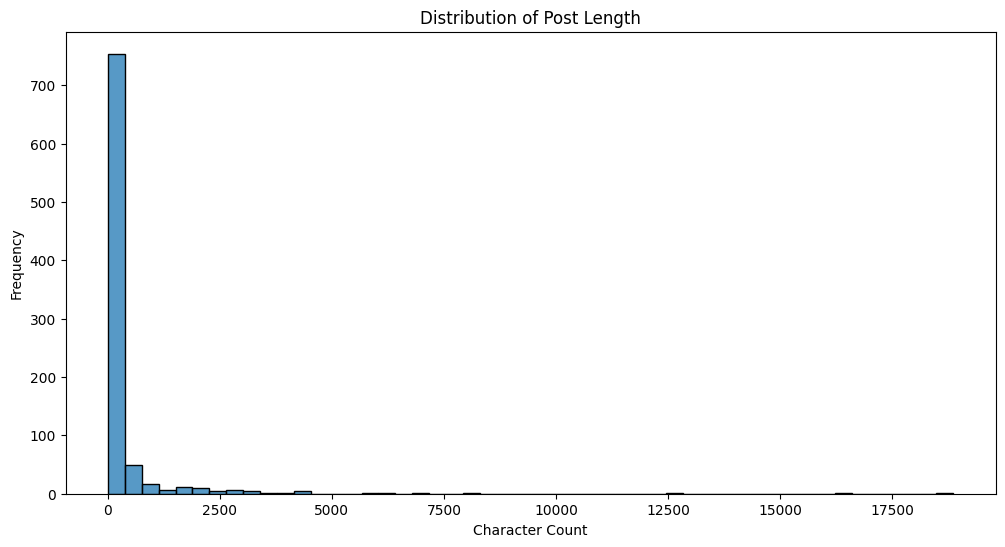

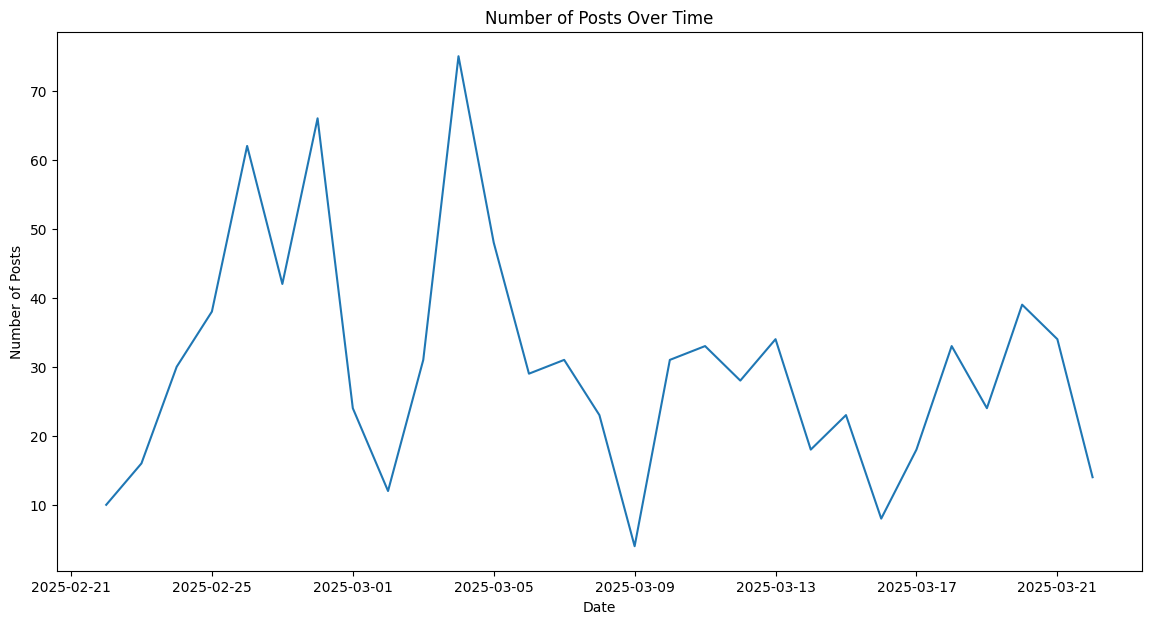

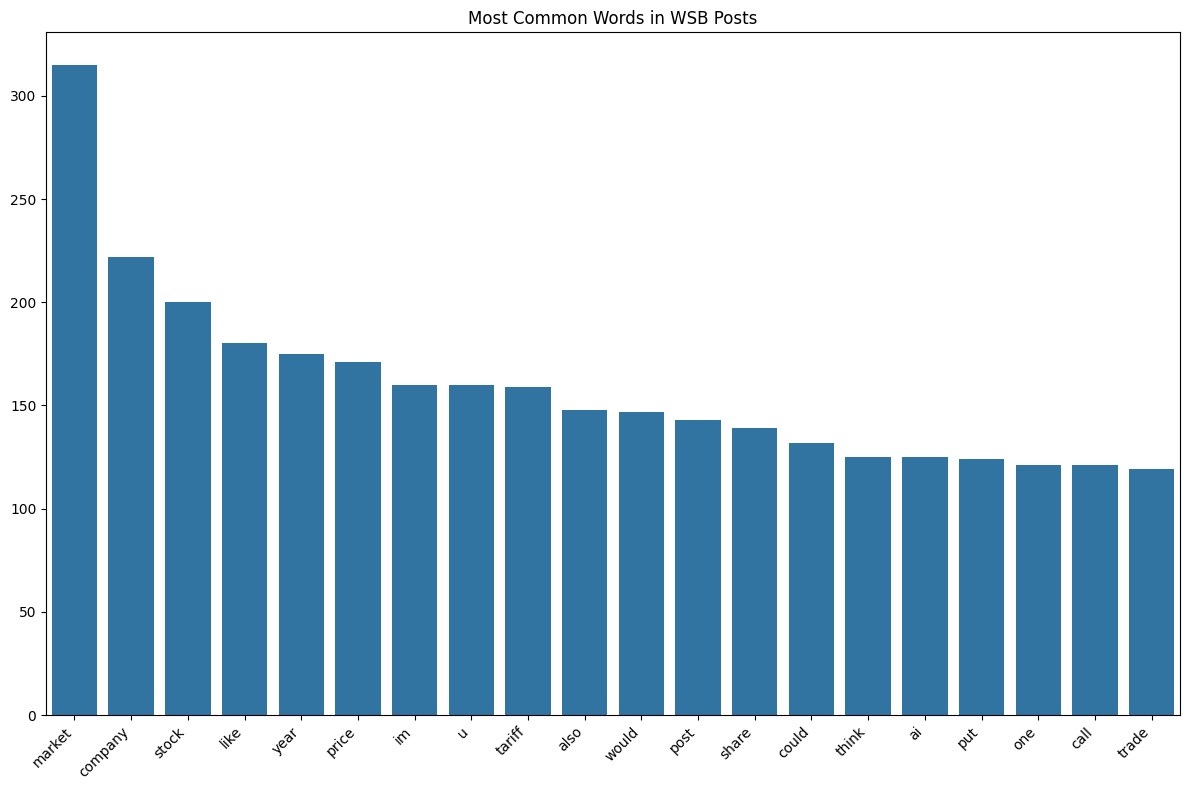

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Text length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], bins=50)
plt.title('Distribution of Post Length')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

# Convert 'created' to datetime format (if it's not already)
try:
    # If 'created' is a timestamp in seconds (common format from Reddit API)
    if 'float' in str(df['created'].dtype) or 'int' in str(df['created'].dtype):
        df['created'] = pd.to_datetime(df['created'], unit='s')
    # If 'created' is a string
    elif 'object' in str(df['created'].dtype):
        df['created'] = pd.to_datetime(df['created'])
except Exception as e:
    print(f"Error converting 'created' column: {e}")

# Time series of post frequency
df['date'] = df['created'].dt.date
post_counts = df.groupby('date').size()
plt.figure(figsize=(14, 7))
post_counts.plot()
plt.title('Number of Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

# Most common words
from collections import Counter
import itertools

all_words = ' '.join(df['clean_body'].fillna('')).split()
word_counts = Counter(all_words)
most_common = word_counts.most_common(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=[word[0] for word in most_common], y=[word[1] for word in most_common])
plt.title('Most Common Words in WSB Posts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

4. Task Formulation and Model Implementations

A. Sentiment Analysis

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
# from transformers import pipeline
from sklearn.preprocessing import LabelEncoder

# You'll need to define sentiment labels first (could be manual labeling or using a rule-based approach)
# For this example, let's assume we've created a 'sentiment' column

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_body'], 
    df['sentiment'], 
    test_size=0.2, 
    random_state=42
)

# Traditional ML models with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit and transform the training labels
y_train_encoded = label_encoder.fit_transform(y_train)

# Store the mapping for reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)  # This will show you which number corresponds to which sentiment

# Transform test labels as well
y_test_encoded = label_encoder.transform(y_test)


# Model 1: Logistic Regression
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_tfidf, y_train)
lr_preds = lr_model.predict(X_test_tfidf)
print("Logistic Regression:")
print(classification_report(y_test, lr_preds))


# Model 2: Random Forest
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train_tfidf, y_train)
rf_preds = rf_model.predict(X_test_tfidf)
print("Random Forest:")
print(classification_report(y_test, rf_preds))


# Model 3: SVM
svm_model = SVC(class_weight='balanced')
svm_model.fit(X_train_tfidf, y_train)
svm_preds = svm_model.predict(X_test_tfidf)
print("SVM:")
print(classification_report(y_test, svm_preds, zero_division=0))


# Model 4: XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_tfidf, y_train_encoded)
xgb_preds_encoded = xgb_model.predict(X_test_tfidf)
xgb_preds = label_encoder.inverse_transform(xgb_preds_encoded)
print("XGBoost:")
print(classification_report(y_test, xgb_preds))



Label mapping: {'negative': 0, 'neutral': 1, 'positive': 2}
Logistic Regression:
              precision    recall  f1-score   support

    negative       0.30      0.21      0.24        29
     neutral       0.50      0.65      0.57        84
    positive       0.37      0.27      0.31        63

    accuracy                           0.44       176
   macro avg       0.39      0.38      0.37       176
weighted avg       0.42      0.44      0.42       176

Random Forest:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        29
     neutral       0.47      0.43      0.45        84
    positive       0.36      0.57      0.44        63

    accuracy                           0.41       176
   macro avg       0.28      0.33      0.30       176
weighted avg       0.36      0.41      0.37       176

SVM:
              precision    recall  f1-score   support

    negative       0.50      0.03      0.06        29
     neutral       0.65     